In [66]:
import pandas as pd

In [67]:
colss= [ 'no','id', 'label', 'statement','subject','speaker','job_tit','state','party', 
       'c9','c10','c11', 'c12', 'c13', 'context', 'justi' ]

In [68]:
df= pd.read_csv("/Users/PV/anaconda3/envs/NLP/dataset/train2.tsv", delimiter='\t',header = None, names= colss)
# usecols=[3,6], names=['colA', 'colB']
#  encoding='utf-8',

In [69]:
df.head()

,no,id,label,statement,subject,speaker,job_tit,state,party,c9,c10,c11,c12,c13,context,justi
0,0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [70]:
import matplotlib.pyplot as plt

[1654, 1995, 2114, 1962, 839, 1676]


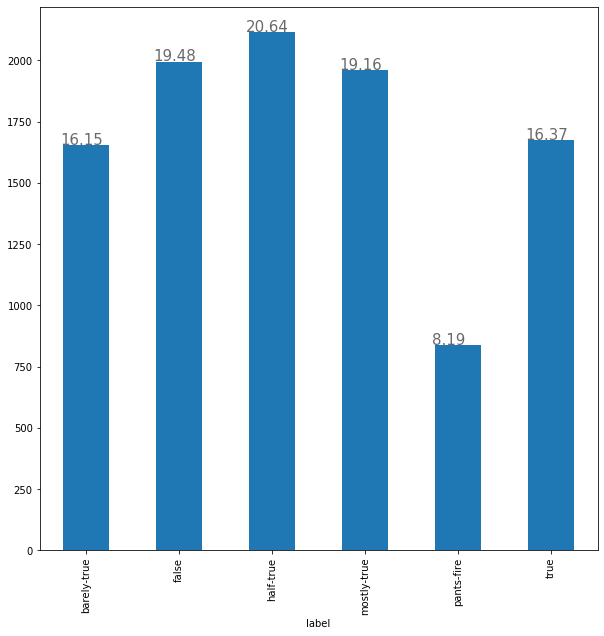

In [71]:
fig = plt.figure(figsize=(10,10))
ax = df.groupby('label').id.count().plot.bar(ylim=0)

totals = []
for i in ax.patches:
    totals.append(i.get_height())

print(totals)
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()-.03, i.get_height()+3, \
            str(round((i.get_height()/total * 100), 2)), fontsize=15,
                color='dimgrey')
plt.show()
# https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [73]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [74]:
df['label_id'] = df['label'].factorize()[0]

In [75]:
label_id_df = df[['label', 'label_id']].drop_duplicates().sort_values('label_id')
label_to_id = dict(label_id_df.values)
id_to_category = dict(label_id_df[['label_id', 'label']].values)

In [76]:
features = tfidf.fit_transform(df.statement).toarray()
labels = df.label_id
features.shape

(10240, 4635)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [78]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
#     MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/Users/PV/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/PV/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/PV/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/PV/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/PV/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: 

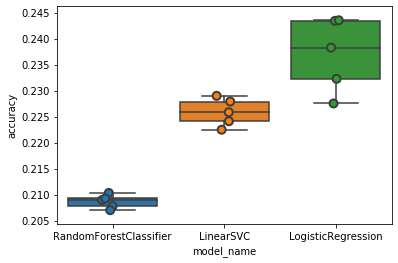

In [79]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [80]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.225878
LogisticRegression        0.237008
RandomForestClassifier    0.208692
Name: accuracy, dtype: float64

In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f